In [2]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import xarray as xr
path = "/Volumes/opto_loc/Data/ACR_39/swi-bl-NNXo.nc"
da = xr.open_dataarray(path)

/tmp/ipykernel_2689292/1504366668.py:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  da = xr.open_dataarray(path)


In [3]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import acr
import warnings
import pingouin as pg
from scipy.stats import shapiro, normaltest
import os
from pathlib import Path

import pingouin as pg

warnings.filterwarnings('ignore')
probe_ord = ['NNXr', 'NNXo']
#hue_ord = [NNXR_GRAY, MAIN_COLOR]
from kdephys.utils.main import td
from cmcrameri import cm as scm

#--------------------------------- Import Publication Functions ---------------------------------#
pub_utils = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py', 'pub_utils')
import pub_utils as pu
data_agg = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py', 'data_agg')
import data_agg as dag

#--------------------------------- Plotting Setup ---------------------------------#
import pubplots as pp
plt.rcdefaults()
plt.style.use('default')
style_path = "/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/plot_styles/acrvec_labels.mplstyle"

#plt.rcdefaults()
#style_path = '/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/plot_styles/acrvec_labels.mplstyle'
#plt.style.use(style_path)

In [4]:
from acr.utils import PAPER_FIGURE_ROOT
nbroot = os.path.join(PAPER_FIGURE_ROOT, 'response_to_review', 'behavior_during_stim')
if not os.path.exists(nbroot):
    os.mkdir(nbroot)

In [5]:
from pause_pipe import *

In [6]:
MAIN_EXP = 'swi'
SUBJECT_TYPE = 'som'
MAIN_COLOR = acr.utils.SOM_BLUE
subjects, exps = pu.get_subject_list(type=SUBJECT_TYPE, exp=MAIN_EXP)

In [ ]:
hds = {}
for subject, exp in zip(subjects, exps):
    hds[subject] = acr.hypnogram_utils.create_acr_hyp_dict(subject, exp)

In [ ]:
subject = 'ACR_40'
exp = acr.utils.sub_swi_exps[subject][0]
recs = acr.info_pipeline.get_exp_recs(subject, exp)

In [ ]:
emg = acr.io.load_raw_data(subject, exp, 'EMGr', update_hypno=False)

In [ ]:
ss, se, pon, poff, ton, toff = acr.stim.get_all_stim_info(subject, exp)

In [ ]:
emgs = {}
for subject, exp in zip(subjects, exps):
    recs = acr.info_pipeline.get_exp_recs(subject, exp)
    recs = [r for r in recs if '-post' not in r]
    emgs[subject] = acr.io.load_concat_raw_data(subject, recs, stores=['EMGr'])

In [13]:
stims = {}
for subject, exp in zip(subjects, exps):
    ss, se, pon, poff, ton, toff = acr.stim.get_all_stim_info(subject, exp)
    stims[subject] = (ss, se)

In [141]:
emg_final.sel(store='EMGr')

<xarray.DataArray (datetime: 9773109)> Size: 39MB
array([-21.006905,  39.182495,  88.10963 , ...,  22.75646 ,  12.744705,
         8.44263 ], shape=(9773109,), dtype=float32)
Coordinates:
    time       (datetime) float64 78MB 8.625e+04 8.625e+04 ... 1.912e+04
    timedelta  (datetime) timedelta64[ns] 78MB 23:57:29.000340500 ... 05:18:4...
  * datetime   (datetime) datetime64[ns] 78MB 2023-09-01T09:00:00.000339500 ....
    channel    int64 8B 1
    recording  (datetime) <U6 235MB 'swi-bl' 'swi-bl' 'swi-bl' ... 'swi' 'swi'
    store      <U4 16B 'EMGr'
Attributes:
    units:    uV
    fs:       508.6263125

In [142]:
pdfs = {}
for subject, exp in zip(subjects, exps):
    ss = stims[subject][0]
    sd_start = ss.normalize()+pd.Timedelta('9h')
    se = stims[subject][1]
    emg_final = emgs[subject].ts(sd_start, se).ch(1).sel(store='EMGr')
    raw_dat = emg_final.values
    pause_df = process_emg_for_pauses(raw_dat, emg_final.fs)
    
    absolute_start_dt = emg_final.datetime.values.min()
    starts = pause_df['start_time_s'].values
    starts_dt = pd.to_timedelta(starts, unit='s') + absolute_start_dt
    ends = pause_df['end_time_s'].values
    ends_dt = pd.to_timedelta(ends, unit='s') + absolute_start_dt
    pause_df['start_datetime'] = starts_dt
    pause_df['end_datetime'] = ends_dt
    pause_df['subject'] = subject
    pause_df['exp'] = exp
    pause_df = pl.from_pandas(pause_df)
    pause_df = acr.oo_utils.label_oodf_hyp_dict_conditions(pause_df, hds[subject])
    pdfs[subject] = pause_df

RMS median: 70.2390, MAD: 26.4164, scale (approx SD): 39.1649
Raw pause fraction: 25.9% of recording
Raw events (before duration filter): 8301
Events after duration filter (0.5-3.0s): 2587
Events after context filter: 1727 (removed 860)
RMS median: 53.9679, MAD: 15.3862, scale (approx SD): 22.8115
Raw pause fraction: 40.8% of recording
Raw events (before duration filter): 22075
Events after duration filter (0.5-3.0s): 3628
Events after context filter: 2849 (removed 779)
RMS median: 5.0738, MAD: 0.5099, scale (approx SD): 0.7560
Raw pause fraction: 39.9% of recording
Raw events (before duration filter): 83511
Events after duration filter (0.5-3.0s): 105
Events after context filter: 95 (removed 10)
RMS median: 39.4353, MAD: 19.7361, scale (approx SD): 29.2607
Raw pause fraction: 20.9% of recording
Raw events (before duration filter): 5095
Events after duration filter (0.5-3.0s): 2129
Events after context filter: 1601 (removed 528)
RMS median: 73.7757, MAD: 32.2929, scale (approx SD): 47.

In [144]:
for pdf in pdfs.values():
    print(len(pdf))

1727
2849
95
1601
1742
1099
801
1144
828
1457


In [145]:
pdf = pl.concat(pdfs.values())

In [7]:
pdf_path = f'./{SUBJECT_TYPE}--pdf.parquet'

In [ ]:
pdf.write_parquet(f'{pdf_path}')

In [17]:
pdf = pl.read_parquet(pdf_path)

In [18]:
pause_counts = pdf.group_by(['subject', 'condition']).agg(pl.count())

In [19]:
pause_counts = pause_counts.filter(pl.col('condition').is_in(['early_sd', 'late_sd', 'stim']))

In [20]:
pause_counts =  pause_counts.sort(['subject', 'condition'])
esd = pause_counts.filter(pl.col('condition')=='early_sd')['count'].to_numpy()
lsd = pause_counts.filter(pl.col('condition')=='late_sd')['count'].to_numpy()
stim = pause_counts.filter(pl.col('condition')=='stim')['count'].to_numpy()

In [21]:
stim_durs = []
for subject in subjects:
    ss = stims[subject][0]
    se = stims[subject][1]
    stim_dur = (se - ss).total_seconds()/60
    stim_durs.append(stim_dur)

In [22]:
esd_rate = esd / 60
lsd_rate = lsd / 60
stim_rate = stim / np.array(stim_durs)

In [23]:
esd_color = '#a8a68f'
lsd_color = '#4b4c4d'

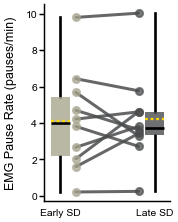

In [39]:
figname = f'emg_pause_rates_esd_vs_lsd_{SUBJECT_TYPE}.svg'
figpath = f'{nbroot}/{figname}'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(esd_rate, lsd_rate, colors=[esd_color, lsd_color], fsize=pp.scale(1.3, 1.6))
    ax.set_ylabel('EMG Pause Rate (pauses/min)')
    ax.set_xticklabels(['Early SD', 'Late SD'])
    f.savefig(figpath, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

In [40]:
# ===== Adjust here =====
stat_name = figname
nnxr = esd_rate
nnxo = lsd_rate
# =========================

_, p = shapiro(nnxr)
print(f"p-value for NNXr: {p}")

_, p = shapiro(nnxo)
print(f"p-value for NNXo: {p}")

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype="hedges")
stat = pg.ttest(nnxr, nnxo, paired=True)
#stat = pg.wilcoxon(nnxr, nnxo)

acr.stats.write_stats_result(
    stat_name,
    "paired_ttest", # wilcoxon
    test_statistic=stat["T"][0], # W-val
    p_value=stat["p-val"][0],
    effect_size_method="g", # RBC
    effect_size=hg, # stat["RBC"][0]
    review=True,
)

src1 = pd.DataFrame({
    "pauses": nnxr,  # data (e.g. SWA)
    "subject": np.arange(len(nnxr)),  # subject index
    "condition": "early_sd",  # probe
})

src2 = pd.DataFrame({
    "pauses": nnxo,  # data (e.g. SWA)
    "subject": np.arange(len(nnxo)),  # subject index
    "condition": "late_sd",  # probe
})
srcdat = pd.concat([src1, src2])
pu.write_source_data(srcdat, stat_name)
stat

p-value for NNXr: 0.8484758354685166
p-value for NNXo: 0.134459784009673


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.215087,9,two-sided,0.834494,"[-1.17, 0.97]",0.038566,0.315,0.051376


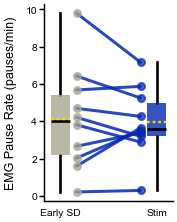

In [41]:
figname = f'emg_pause_rates_esd_vs_stim_{SUBJECT_TYPE}.svg'
figpath = f'{nbroot}/{figname}'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(esd_rate, stim_rate, colors=[esd_color, MAIN_COLOR], fsize=pp.scale(1.3, 1.6))
    ax.set_ylabel('EMG Pause Rate (pauses/min)')
    ax.set_xticklabels(['Early SD', 'Stim'])
    f.savefig(figpath, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

In [42]:
# ===== Adjust here =====
stat_name = figname
nnxr = esd_rate
nnxo = stim_rate
# =========================

_, p = shapiro(nnxr)
print(f"p-value for NNXr: {p}")

_, p = shapiro(nnxo)
print(f"p-value for NNXo: {p}")

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype="hedges")
stat = pg.ttest(nnxr, nnxo, paired=True)
#stat = pg.wilcoxon(nnxr, nnxo)

acr.stats.write_stats_result(
    stat_name,
    "paired_ttest", # wilcoxon
    test_statistic=stat["T"][0], # W-val
    p_value=stat["p-val"][0],
    effect_size_method="g", # RBC
    effect_size=hg, # stat["RBC"][0]
    review=True,
)

src1 = pd.DataFrame({
    "pauses": nnxr,  # data (e.g. SWA)
    "subject": np.arange(len(nnxr)),  # subject index
    "condition": "early_sd",  # probe
})

src2 = pd.DataFrame({
    "pauses": nnxo,  # data (e.g. SWA)
    "subject": np.arange(len(nnxo)),  # subject index
    "condition": "stim",  # probe
})
srcdat = pd.concat([src1, src2])
pu.write_source_data(srcdat, stat_name)
stat

p-value for NNXr: 0.8484758354685166
p-value for NNXo: 0.7083692289299486


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.387023,9,two-sided,0.707731,"[-0.82, 1.16]",0.07172,0.329,0.054767


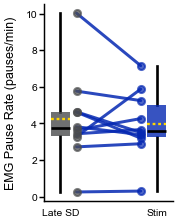

In [43]:
figname = f'emg_pause_rates_lsd_vs_stim_{SUBJECT_TYPE}.svg'
figpath = f'{nbroot}/{figname}'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(lsd_rate, stim_rate, colors=[lsd_color, MAIN_COLOR], fsize=pp.scale(1.3, 1.6))
    ax.set_ylabel('EMG Pause Rate (pauses/min)')
    ax.set_xticklabels(['Late SD', 'Stim'])
    plt.show()
    f.savefig(figpath, dpi=300, bbox_inches='tight', transparent=True)

In [44]:
# ===== Adjust here =====
stat_name = figname
nnxr = lsd_rate
nnxo = stim_rate
# =========================

_, p = shapiro(nnxr)
print(f"p-value for NNXr: {p}")

_, p = shapiro(nnxo)
print(f"p-value for NNXo: {p}")

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype="hedges")
stat = pg.ttest(nnxr, nnxo, paired=True)
#stat = pg.wilcoxon(nnxr, nnxo)

acr.stats.write_stats_result(
    stat_name,
    "paired_ttest", # wilcoxon
    test_statistic=stat["T"][0], # W-val
    p_value=stat["p-val"][0],
    effect_size_method="g", # RBC
    effect_size=hg, # stat["RBC"][0]
    review=True,
)

src1 = pd.DataFrame({
    "pauses": nnxr,  # data (e.g. SWA)
    "subject": np.arange(len(nnxr)),  # subject index
    "condition": "late_sd",  # probe
})

src2 = pd.DataFrame({
    "pauses": nnxo,  # data (e.g. SWA)
    "subject": np.arange(len(nnxo)),  # subject index
    "condition": "stim",  # probe
})
srcdat = pd.concat([src1, src2])
pu.write_source_data(srcdat, stat_name)
stat

p-value for NNXr: 0.134459784009673
p-value for NNXo: 0.7083692289299486


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.597097,9,two-sided,0.565159,"[-0.75, 1.3]",0.122451,0.359,0.063964


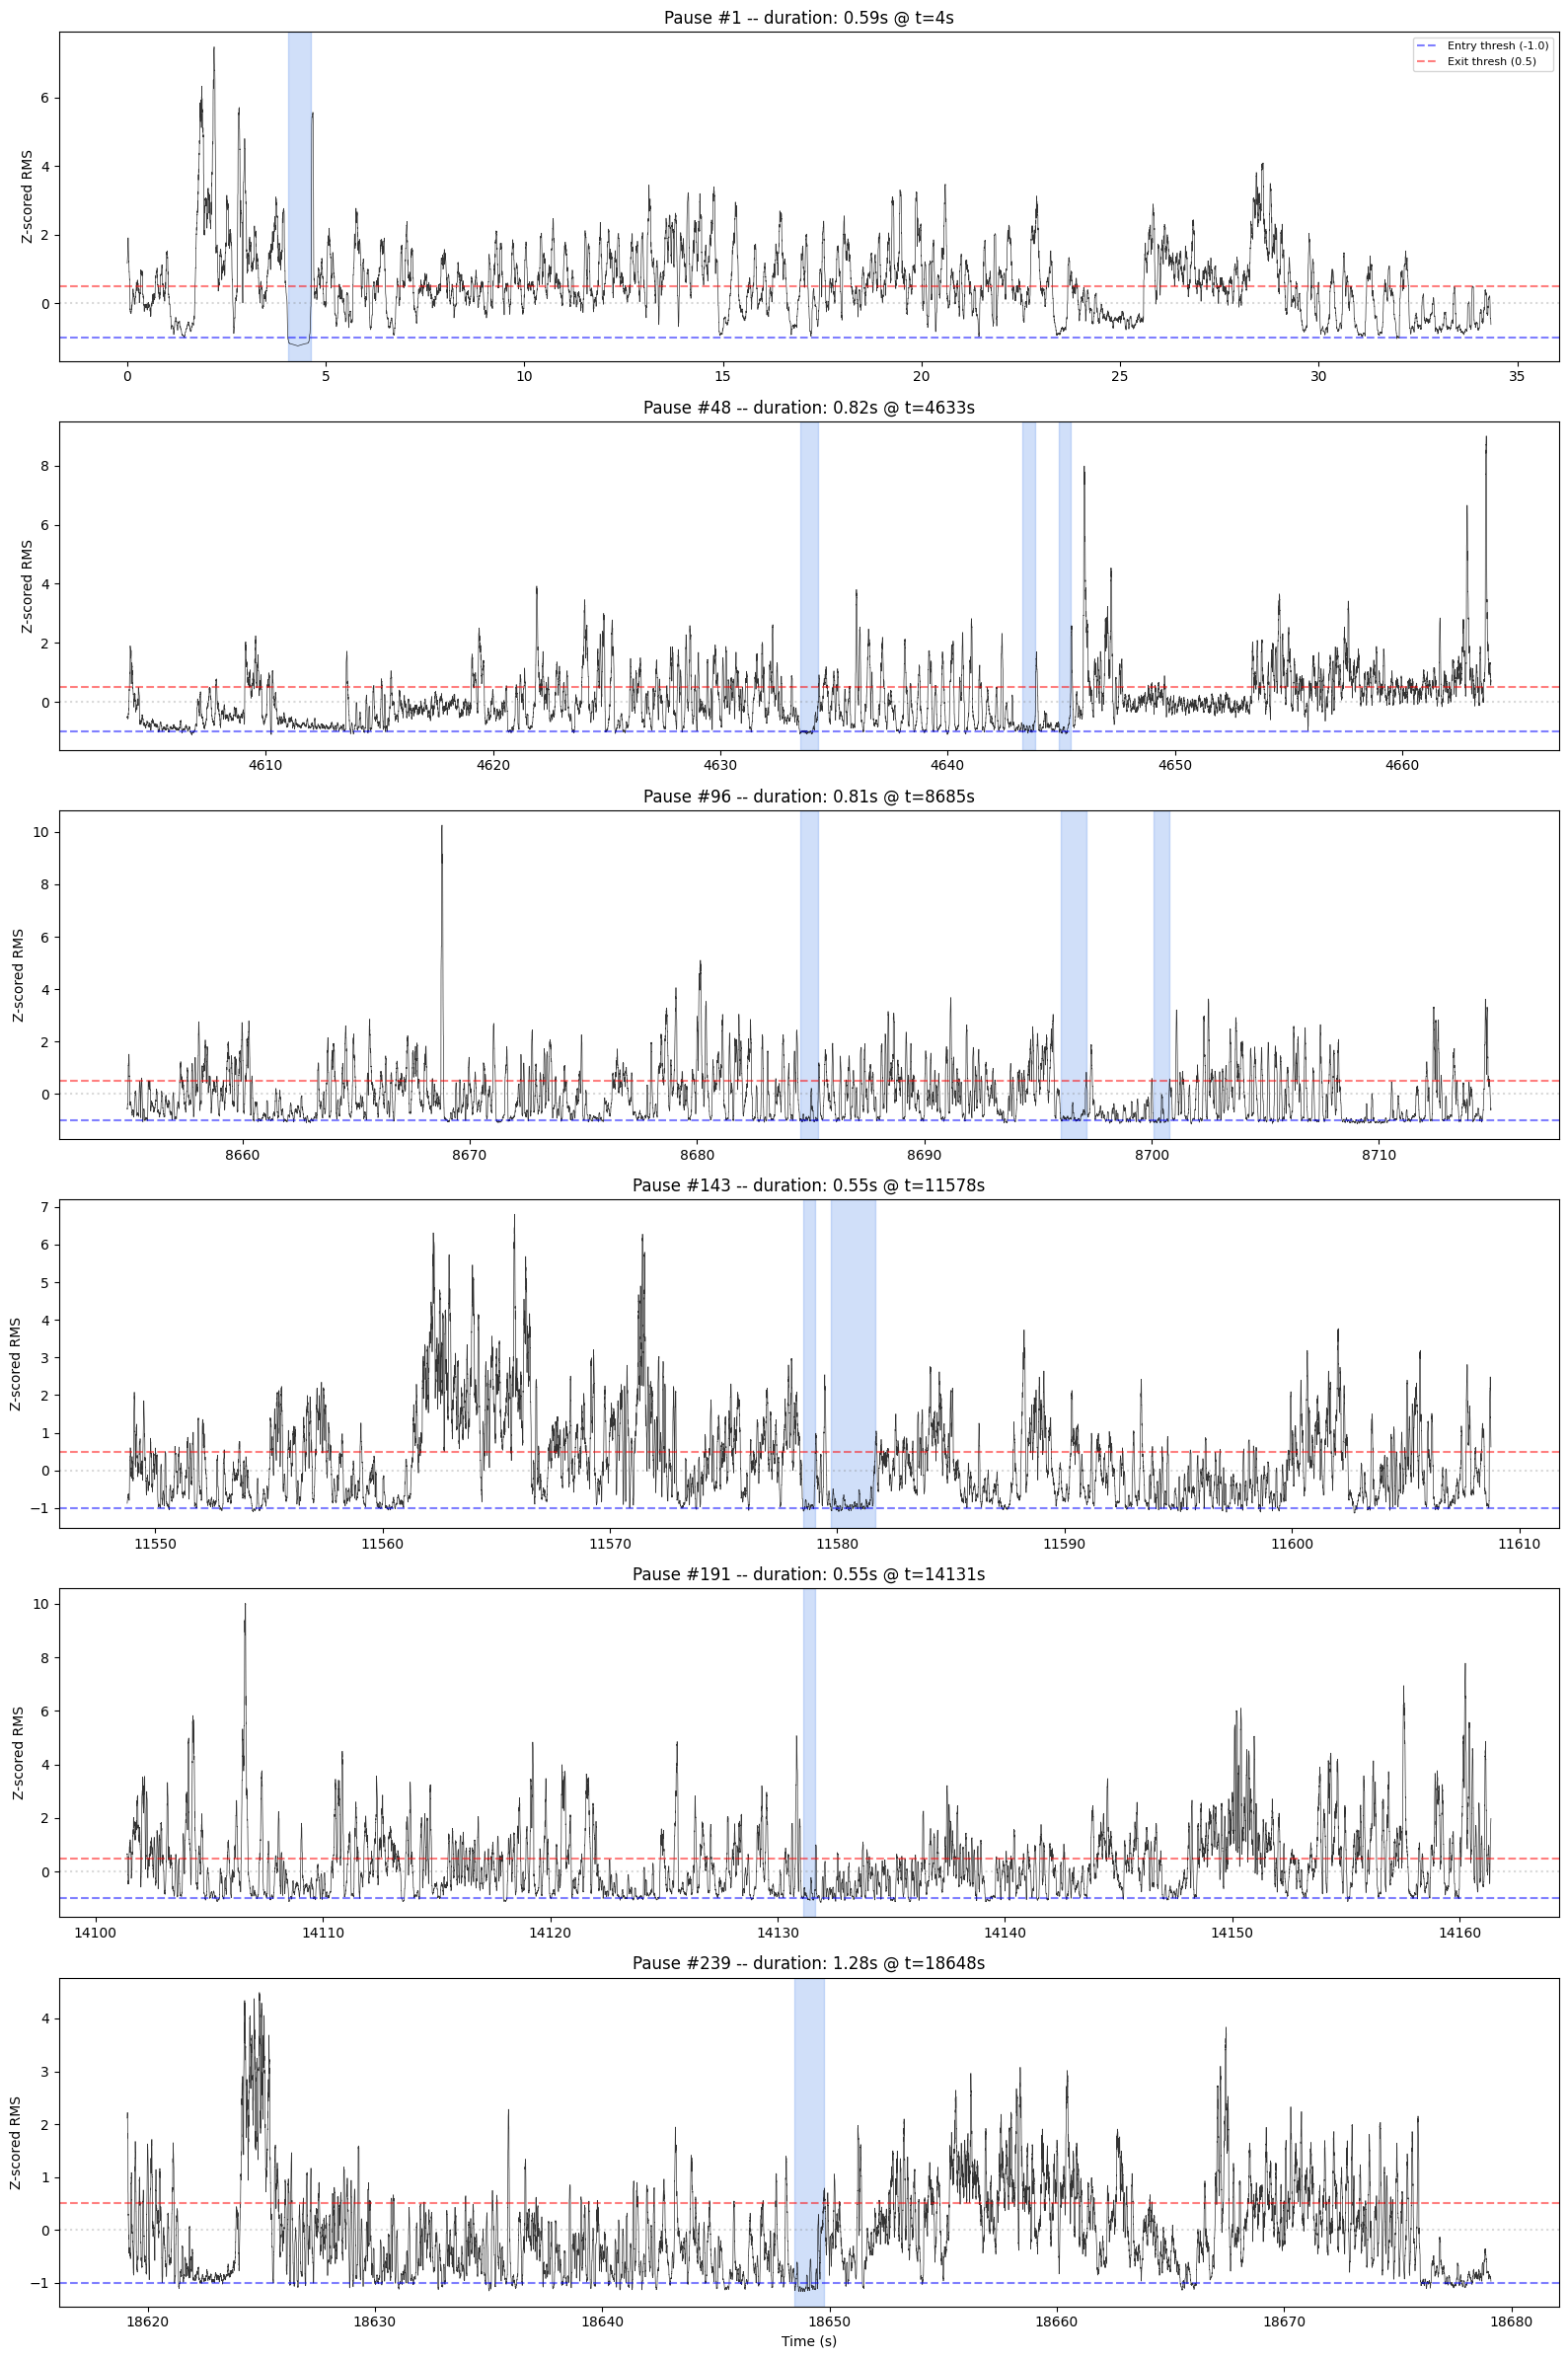

In [ ]:
# ===================== VISUALIZATION: EXAMPLE TRACES ===================== #
# Show 60-second windows with raw EMG, RMS envelope, z-scored RMS, and detected pauses

if len(pause_df) > 0:
    # Pick a few example windows centered on detected pauses
    n_examples = min(6, len(pause_df))
    # Spread examples across the recording
    example_indices = np.linspace(0, len(pause_df) - 1, n_examples, dtype=int)
    
    fig, axes = plt.subplots(n_examples, 1, figsize=(16, 4 * n_examples), sharex=False)
    if n_examples == 1:
        axes = [axes]
    
    for ax_idx, evt_idx in enumerate(example_indices):
        evt = pause_df.iloc[evt_idx]
        # 60-second window centered on the pause
        center_sample = int((evt['start_sample'] + evt['end_sample']) / 2)
        window_samples = int(30 * fs)  # 30s on each side
        w_start = max(0, center_sample - window_samples)
        w_end = min(len(raw_dat), center_sample + window_samples)
        
        t_window = np.arange(w_start, w_end) / fs
        ax = axes[ax_idx]
        
        # Plot z-scored RMS
        ax.plot(t_window, z_rms[w_start:w_end], color='k', linewidth=0.5, alpha=0.8)
        ax.axhline(low_thresh, color='blue', linestyle='--', alpha=0.5, label=f'Entry thresh ({low_thresh})')
        ax.axhline(high_thresh, color='red', linestyle='--', alpha=0.5, label=f'Exit thresh ({high_thresh})')
        ax.axhline(0, color='gray', linestyle=':', alpha=0.3)
        
        # Shade all pauses in this window
        for _, p in pause_df.iterrows():
            p_start = int(p['start_sample'])
            p_end = int(p['end_sample'])
            if p_start < w_end and p_end > w_start:
                ax.axvspan(max(p_start, w_start) / fs, min(p_end, w_end) / fs,
                          alpha=0.3, color='cornflowerblue', label='_')
        
        ax.set_ylabel('Z-scored RMS')
        ax.set_title(f'Pause #{evt_idx+1} -- duration: {evt["duration_s"]:.2f}s @ t={evt["start_time_s"]:.0f}s')
        if ax_idx == 0:
            ax.legend(loc='upper right', fontsize=8)
    
    axes[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()
else:
    print("No pauses detected -- cannot generate example traces.")

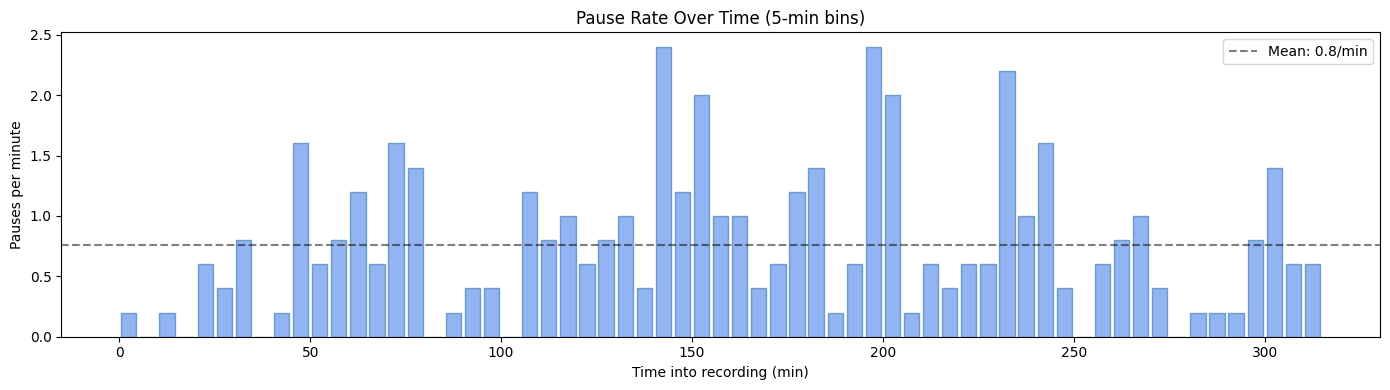

In [81]:
# ===================== VISUALIZATION: PAUSE RATE OVER TIME ===================== #
# Shows how pausing behavior evolves across the recording

if len(pause_df) > 0:
    # Compute pause rate in 5-minute bins
    bin_width_min = 5
    bin_width_s = bin_width_min * 60
    n_bins = int(np.ceil(total_recording_s / bin_width_s))
    bin_edges = np.arange(0, (n_bins + 1) * bin_width_s, bin_width_s)
    
    pause_starts = pause_df['start_time_s'].values
    counts, _ = np.histogram(pause_starts, bins=bin_edges)
    rates = counts / bin_width_min  # pauses per minute
    bin_centers_min = (bin_edges[:-1] + bin_width_s / 2) / 60
    
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.bar(bin_centers_min, rates, width=bin_width_min * 0.8, color='cornflowerblue', alpha=0.7, edgecolor='steelblue')
    ax.set_xlabel('Time into recording (min)')
    ax.set_ylabel(f'Pauses per minute')
    ax.set_title(f'Pause Rate Over Time ({bin_width_min}-min bins)')
    ax.axhline(rates.mean(), color='k', linestyle='--', alpha=0.5, label=f'Mean: {rates.mean():.1f}/min')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No pauses detected -- cannot plot pause rate.")

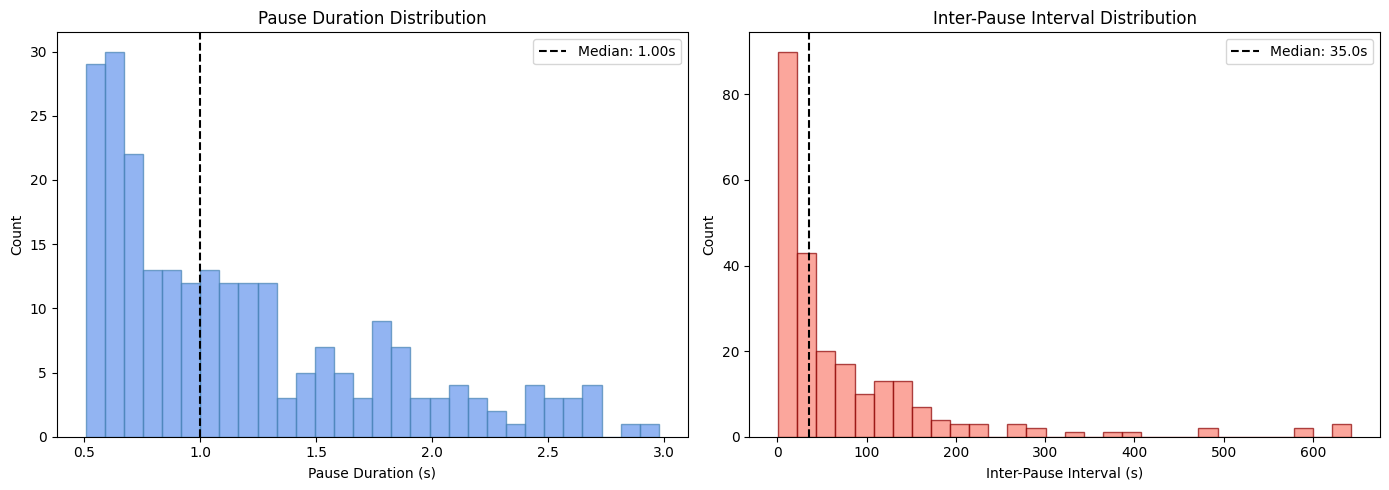

In [82]:
# ===================== VISUALIZATION: DISTRIBUTIONS ===================== #
# Duration distribution and inter-pause interval distribution

if len(pause_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Duration distribution
    ax = axes[0]
    ax.hist(pause_df['duration_s'], bins=30, color='cornflowerblue', edgecolor='steelblue', alpha=0.7)
    ax.axvline(pause_df['duration_s'].median(), color='k', linestyle='--',
               label=f'Median: {pause_df["duration_s"].median():.2f}s')
    ax.set_xlabel('Pause Duration (s)')
    ax.set_ylabel('Count')
    ax.set_title('Pause Duration Distribution')
    ax.legend()
    
    # Inter-pause interval distribution
    ax = axes[1]
    if len(pause_df) > 1:
        intervals = np.diff(pause_df['start_time_s'].values)
        ax.hist(intervals, bins=30, color='salmon', edgecolor='darkred', alpha=0.7)
        ax.axvline(np.median(intervals), color='k', linestyle='--',
                   label=f'Median: {np.median(intervals):.1f}s')
        ax.set_xlabel('Inter-Pause Interval (s)')
        ax.set_ylabel('Count')
        ax.set_title('Inter-Pause Interval Distribution')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Need >1 pause\nfor intervals', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
else:
    print("No pauses detected -- cannot plot distributions.")